In [1]:
import torch,torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import pandas as pd
import wandb
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
PROJECT_NAME = 'Car-Object-Detection-V7-Learning-Detectron2-V2'

In [2]:
data = pd.read_csv('./data.csv')

In [3]:
data

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [4]:
img = cv2.imread('./data/vid_4_9860.jpg')

In [5]:
xmin,ymin,xmax,ymax = 0,198,49,236

In [6]:
x = xmin
y = ymin
w = xmax - xmin
h = ymax - ymin

In [7]:
crop = img[y:y+h,x:x+w]

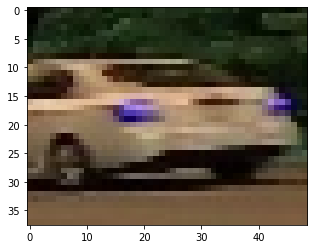

In [8]:
plt.imshow(crop)

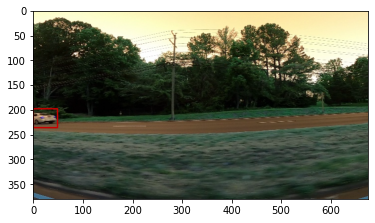

In [9]:
plt.imshow(cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2))

In [10]:
def load_data():
    records = []
    for idx in tqdm(range(len(data))):
        record = {}
        info = data.iloc[idx]
        file_path = f'./data/{info["image"]}'
        record['file_name'] = file_path
        record['height'],record['width'] = cv2.imread(file_path).shape[:2]
        record['image_id'] = idx
        record['annotations'] = [
            {
                'bbox':[info['xmin'],info['ymin'],info['xmax'],info['ymax']],
                'bbox_mode':BoxMode.XYXY_ABS,
                'category_id':0
            }
        ]
        records.append(record)
    return records

In [11]:
labels = ['car']

In [12]:
DatasetCatalog.register('data',lambda : load_data())
MetadataCatalog.get('data').set(thing_classes=labels)
metadata = MetadataCatalog.get('data')

In [13]:
model = "COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"

In [15]:
wandb.init(project=PROJECT_NAME,name='baseline')
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model))
cfg.DATASETS.TRAIN = ('data')
cfg.DATASETS.TEST = ()
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.DATASETS.NUM_WORKERS = 2
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(labels)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
cfg.MODEL.WEIGHTS = './output/model_final.pth'
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator('data',output_dir='./output/')
val_loader = build_detection_test_loader(cfg,'data')
metrics = inference_on_dataset(predictor.model,val_loader,evaluator)
wandb.log(metrics)
img = cv2.imread('./data/vid_4_10900.jpg')
v = Visualizer(img[:,:,::-1],metadata=metadata)
v = v.draw_instance_predictions(predictor(img)['instances'].to('cpu'))
v = v.get_image()[:,:,::-1]
plt.figure(figsize=(12,6))
plt.imshow(v)
plt.savefig('./img.png')
plt.close()
wandb.log({'Img':wandb.Image(cv2.imread('./img.png'))})
wandb.finish()

wandb: Waiting for W&B process to finish, PID 49870
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20211017_233825-1vgqsg1j/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20211017_233825-1vgqsg1j/logs/debug-internal.log
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: 
wandb: Synced baseline: https://app.wandb.ai/ranuga-d/Car-Object-Detection-V7-Learning-Detectron2-V2/runs/1vgqsg1j
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.0
wandb: Run data is saved locally in wandb/run-20211017_233841-2v0xtca4
wandb: Syncing run baseline



[10/17 23:38:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)


100%|████████████████████████████████████████| 559/559 [00:01<00:00, 353.50it/s]

[10/17 23:38:48 d2.data.build]: Removed 0 images with no usable annotations. 559 images left.
[10/17 23:38:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/17 23:38:48 d2.data.build]: Using training sampler TrainingSampler
[10/17 23:38:48 d2.data.common]: Serializing 559 elements to byte tensors and concatenating them all ...
[10/17 23:38:48 d2.data.common]: Serialized dataset takes 0.19 MiB



2021-10-17 23:38:49.673678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model 

[10/17 23:38:53 d2.engine.train_loop]: Starting training from iteration 0
[10/17 23:39:01 d2.utils.events]:  eta: 0:15:45  iter: 19  total_loss: 1.341  loss_cls: 0.8473  loss_box_reg: 0.4543  loss_rpn_cls: 0.01089  loss_rpn_loc: 0.004875  time: 0.3798  data_time: 0.0153  lr: 4.9953e-06  max_mem: 2283M
[10/17 23:39:08 d2.utils.events]:  eta: 0:15:17  iter: 39  total_loss: 1.23  loss_cls: 0.7416  loss_box_reg: 0.4363  loss_rpn_cls: 0.007718  loss_rpn_loc: 0.0059  time: 0.3710  data_time: 0.0026  lr: 9.9902e-06  max_mem: 2283M
[10/17 23:39:16 d2.utils.events]:  eta: 0:15:09  iter: 59  total_loss: 1.036  loss_cls: 0.5696  loss_box_reg: 0.4776  loss_rpn_cls: 0.009914  loss_rpn_loc: 0.0048  time: 0.3711  data_time: 0.0027  lr: 1.4985e-05  max_mem: 2283M
[10/17 23:39:23 d2.utils.events]:  eta: 0:15:03  iter: 79  total_loss: 0.8626  loss_cls: 0.4087  loss_box_reg: 0.4346  loss_rpn_cls: 0.01064  loss_rpn_loc: 0.005369  time: 0.3731  data_time: 0.0028  lr: 1.998e-05  max_mem: 2283M
[10/17 23:39:

100%|████████████████████████████████████████| 559/559 [00:01<00:00, 354.32it/s]

[10/17 23:53:30 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[10/17 23:53:30 d2.data.datasets.coco]: Conversion finished, #images: 559, #annotations: 559
[10/17 23:53:30 d2.data.datasets.coco]: Caching COCO format annotations at './output/data_coco_format.json' ...


100%|████████████████████████████████████████| 559/559 [00:01<00:00, 358.93it/s]

[10/17 23:53:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/17 23:53:32 d2.data.common]: Serializing 559 elements to byte tensors and concatenating them all ...
[10/17 23:53:32 d2.data.common]: Serialized dataset takes 0.19 MiB
[10/17 23:53:32 d2.evaluation.evaluator]: Start inference on 559 batches


[10/17 23:53:34 d2.evaluation.evaluator]: Inference done 11/559. Dataloading: 0.0007 s/iter. Inference: 0.1810 s/iter. Eval: 0.0001 s/iter. Total: 0.1818 s/iter. ETA=0:01:39
[10/17 23:53:39 d2.evaluation.evaluator]: Inference done 39/559. Dataloading: 0.0009 s/iter. Inference: 0.1818 s/iter. Eval: 0.0001 s/iter. Total: 0.1829 s/iter. ETA=0:01:35
[10/17 23:53:44 d2.evaluation.evaluator]: Inference done 61/559. Dataloading: 0.0010 s/iter. Inference: 0.2008 s/iter. Eval: 0.0001 s/iter. Total: 0.2019 s/iter. ETA=0:01:40
[10/17 23:53:49 d2.evaluation.evaluator]: Inference done 86/559. Dataloading: 0.0010 s/iter. Inference: 0.2012 s/iter. Eval: 0.0001 s/iter. Total: 0.2024 s/iter. ETA=0:01:35
[10/17 23:53:54 d2.evaluation.evaluator]: Inference done 110/559. Dataloading: 0.0009 s/iter. Inference: 0.2028 s/iter. Eval: 0.0001 s/iter. Total: 0.2040 s/iter. ETA=0:01:31
[10/17 23:53:59 d2.evaluation.evaluator]: Inference done 137/559. Dataloading: 0.0009 s/iter. Inference: 0.1991 s/iter. Eval: 0.0

wandb: Waiting for W&B process to finish, PID 50266
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20211017_233841-2v0xtca4/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20211017_233841-2v0xtca4/logs/debug-internal.log
wandb: Run summary:
wandb:        _step 1
wandb:     _runtime 998
wandb:   _timestamp 1634495123
wandb: Run history:
wandb:        _step ▁█
wandb:     _runtime ▁▁
wandb:   _timestamp ▁▁
wandb: Synced 5 W&B file(s), 1 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: 
wandb: Synced baseline: https://app.wandb.ai/ranuga-d/Car-Object-Detection-V7-Learning-Detectron2-V2/runs/2v0xtca4


In [16]:
torch.save(cfg,'cfg.pt')
torch.save(cfg,'cfg.pth')
torch.save(predictor,'predictor.pt')
torch.save(predictor,'predictor.pth')
torch.save(evaluator,'evaluator.pt')
torch.save(evaluator,'evaluator.pth')
torch.save(v,'img.pt')
torch.save(v,'img.pth')
torch.save(model,'model.pt')
torch.save(model,'model.pth')
torch.save(labels,'labels.pt')
torch.save(labels,'labels.pth')
torch.save(metrics,'metrics.pt')
torch.save(metrics,'metrics.pth')